In [1]:
import os
import random
import torch
import cv2
import math
import sys
import json
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch.autograd import Variable
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
from torch.autograd import Function
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn.modules.module import Module
from pprint import pprint
from svgpathtools import svg2paths

In [2]:
prefix = ''
path = 'data/'

In [3]:
def distance(x0, y0, x1, y1):
    return math.sqrt(pow(x0 - x1, 2) + pow(y0 - y1, 2))

In [35]:
class PathManager:
        
    def __init__(self, path, text):
        self.path = path
        self.text = text
    
    def distance(self, t1, t2):
        p1 = self.path.point(t2)
        p2 = self.path.point(t1)
        return distance(p1.real, p1.imag, p2.real, p2.imag)
    
    def tangentAngle(self, t, eps=0.0001):
#         tangent = self.path.unit_tangent(t)
        p1 = self.path.point(max(0, t - eps))
        p2 = self.path.point(min(1, t + eps))
        
        dx = p2.real - p1.real
        dy = p1.imag - p1.imag
        
        tangent = complex(dx, dy)
    
        return -math.atan2(tangent.imag, tangent.real)
        
    
    def findNextDistance(self, t, distance):
        lo = t
        hi = 1
        
        last = None
        
        while (lo <= hi):
            mid = (lo + hi) / 2
            if last == mid:
                break
            d = self.distance(t, mid)
            if (d < distance):
                lo = mid
            else:
                hi = mid
            last = mid
        
        return last
    
    def findMidDistance(self, t1, t2):
        lo = t
        hi = 1
        
        last = None
        
        while (lo <= hi):
            mid = (lo + hi) / 2
            if last == mid:
                break
            d = self.distance(t, mid)
            if (d < distance):
                lo = mid
            else:
                hi = mid
            last = mid
        
        return last
    
    def segmentFixedDistance(self, distance, lo=0.0, hi=1.0):
        positions = [lo]
        while (lo < hi):
            nt = self.findNextDistance(lo, distance)
            positions.append(min(hi, nt))
            lo = nt
        
        points_x = []
        points_y = []
        radians = []
        
        for position in positions:
            point = self.path.point(position)
            angle = self.tangentAngle(position)
            points_x.append(point.real)
            points_y.append(point.imag)
            radians.append(angle)
        
        return list(zip(points_x, points_y, radians))
    
    def _segmentEqualDistance(self, maxDistance, lo=0.0, hi=1.0):
        if self.distance(lo, hi) > maxDistance:
            last = None
            l = lo
            h = hi
            while (l <= h):
                mid = (l + h) / 2
                if last == mid:
                    break
                    
                d1 = self.distance(lo, mid)
                d2 = self.distance(mid, hi)
                
                if (d1 < d2):
                    l = mid
                else:
                    h = mid
                    
                last = mid
                
            r1 = self._segmentEqualDistance(maxDistance, lo, last)
            r2 = self._segmentEqualDistance(maxDistance, last, hi)
            r1.pop()
            return r1 + r2
        else:
            return [lo, hi]
        
    def segmentEqualDistance(self, maxDistance, lo=0.0, hi=1.0):
        positions = self._segmentEqualDistance(maxDistance, lo, hi)
        points_x = []
        points_y = []
        radians = []
        
        for position in positions:
            point = self.path.point(position)
            angle = self.tangentAngle(position)
            points_x.append(point.real)
            points_y.append(point.imag)
            radians.append(angle)
        
        return list(zip(points_x, points_y, radians))
    
    def __str__(self):
        return 'Text: "%s"' % self.text
    
    def __repr__(self):
        return str(self)
        

class PaperManager:
    
    def __init__(self, path):
        self.name = path.split('/')[-1]
        self.img = os.path.join(path, self.name + '.jpg')
        self.svg = os.path.join(path, self.name + '.svg')
        self.txt = os.path.join(path, self.name + '.txt')
        paths, attributes = svg2paths(self.svg)        
        self.lines = paths
        self.texts = [line.strip() for line in open(self.txt).readlines()]
        
    def getOriginal(self):
        return cv2.imread(self.img)
    
    def getGrayscale(self):
        return cv2.imread(self.img, 0)
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):
        return PathManager(self.lines[idx], self.texts[idx])
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return ' '.join(['Paper:', str(self), 'Lines:', str(len(self))])
    

class DatasetManager:
    
    def __init__(self, path):
        self.papers = list(sorted(glob.glob(path + '*')))
        
    def __len__(self):
        return len(self.papers)
    
    def __getitem__(self, idx):
        return PaperManager(self.papers[idx])
    
    def __str__(self):
        return ' '.join(['Dataset:', str(self.papers)])
    
    def __repr__(self):
        return str(self)

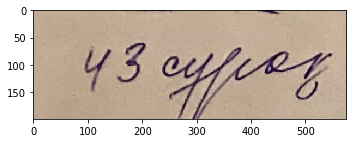

Text: "43 сұрақ"


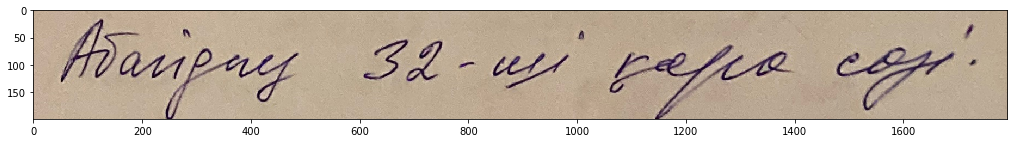

Text: "Абайдың 32-ші қара сөзі."


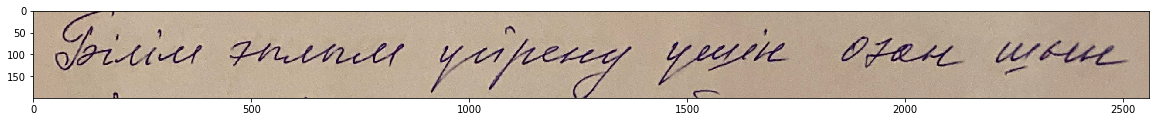

Text: "Білім ғылым үйрену үшін оған шын"


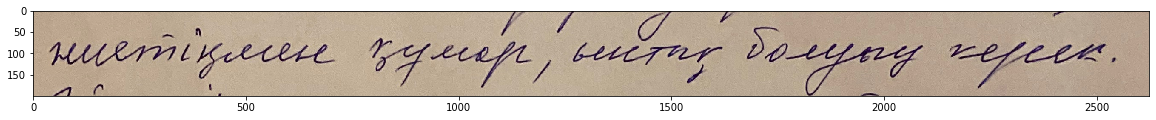

Text: "ниетіңмен құмар, ынтық болуың керек."


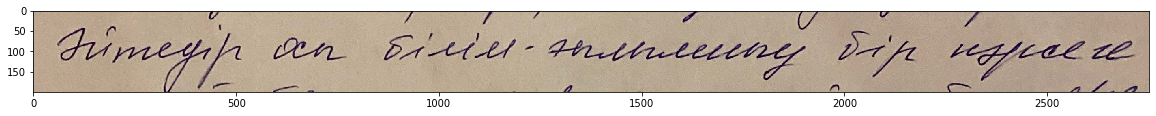

Text: "Әйтеуір осы білім-ғылымның бір нәрсеге"


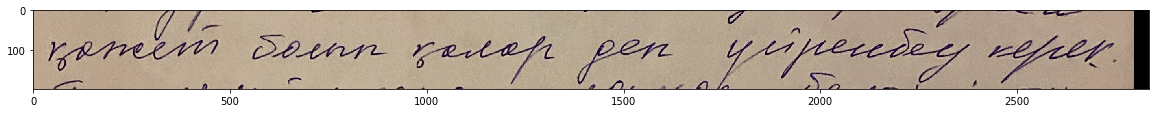

Text: "қажет болып қалар деп үйренбеу керек."


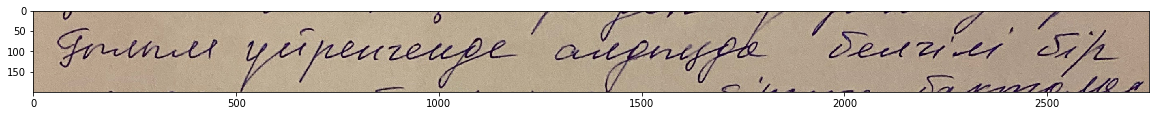

Text: "Ғылым үйренгенде алдыңда белгілі бір"


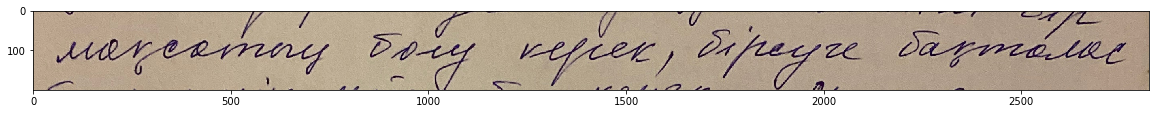

Text: "мақсатың болу керек, біреуге бақталас"


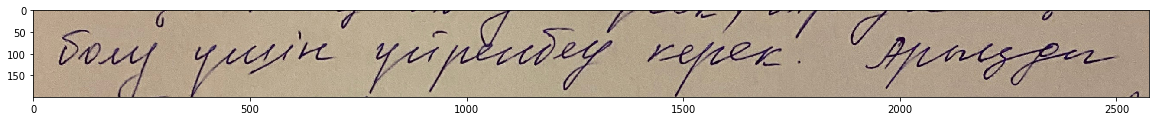

Text: "болу үшін үйренбеу керек. Арыңды"


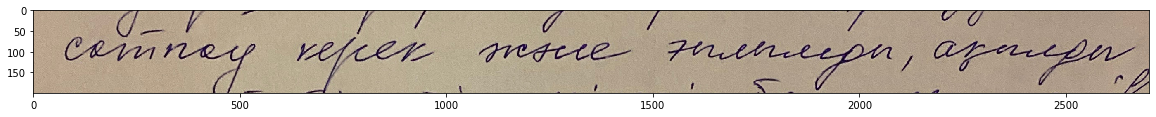

Text: "сатпау керек және ғылымды, ақылды"


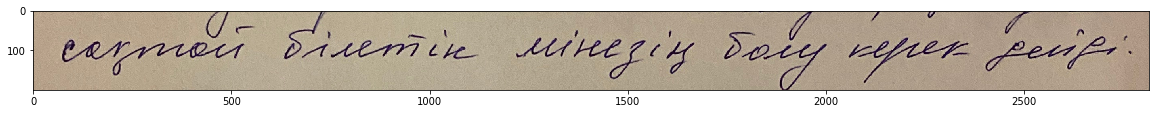

Text: "сақтай білетін мінезің болу керек дейді."


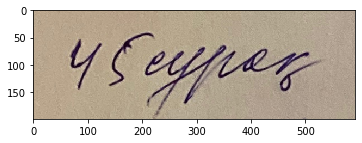

Text: "45 сұрақ"


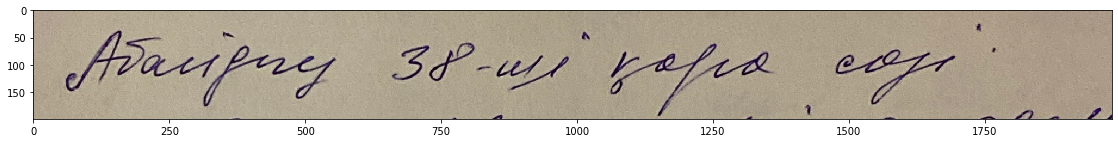

Text: "Абайдың 38-ші қара сөзі"


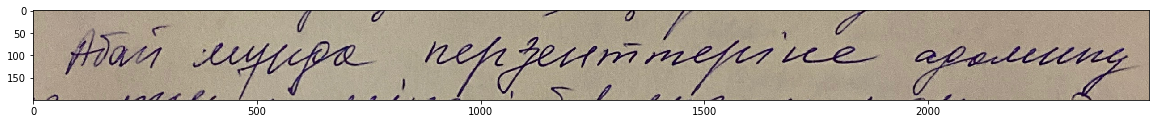

Text: "Абай мұнда перзенттеріне адамның"


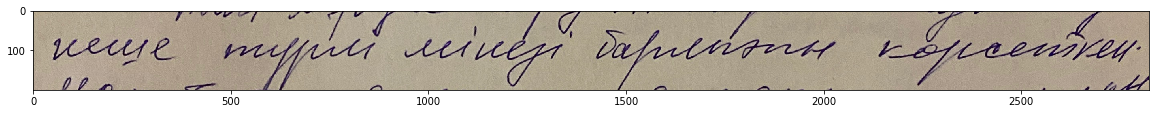

Text: "неше түрлі мінезі барлығын көрсеткен."


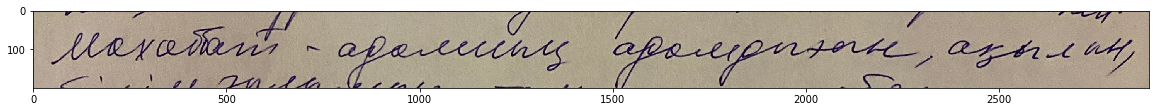

Text: "Махаббат - адамның адамдығын, ақылын,"


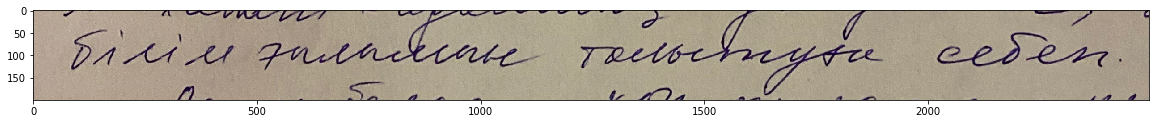

Text: "білім ғылымын толытуға себеп."


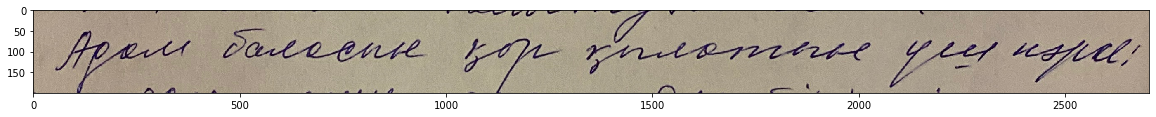

Text: "Адам баласын қор қылатын үш нәрсе:"


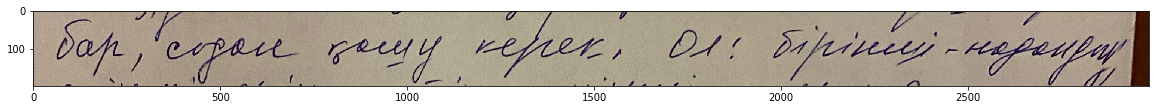

Text: "бар, содан қашу керек. Ол: бірінші-надандық,"


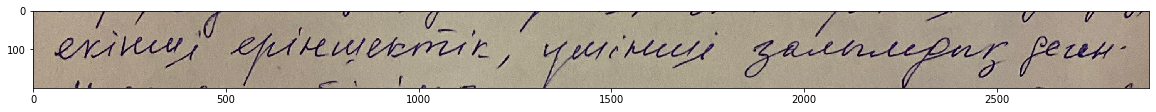

Text: "екінші еріншектік, үшінші залымдық деген."


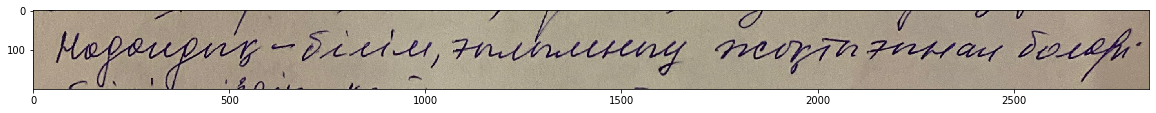

Text: "Надандық-білім, ғылымның жоқтығынан болар."


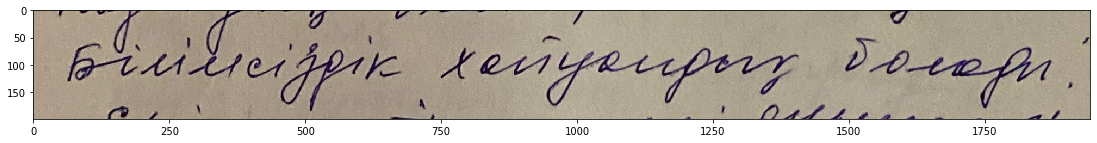

Text: "Білімсіздік хайуандылық болады."


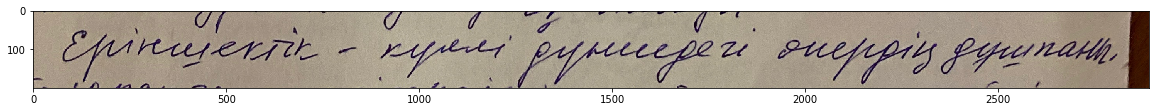

Text: "Еріншектік-күллі дүниедегі өнердің дұшпаны."


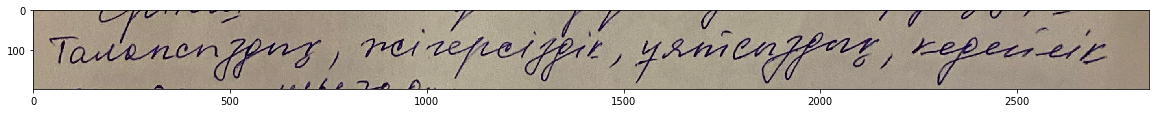

Text: "Талапсыздық,жігерсіздік,ұятсыздық,кедейлік"


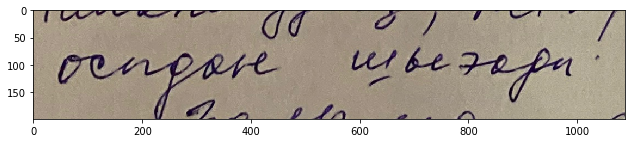

Text: "осыдан шығады."


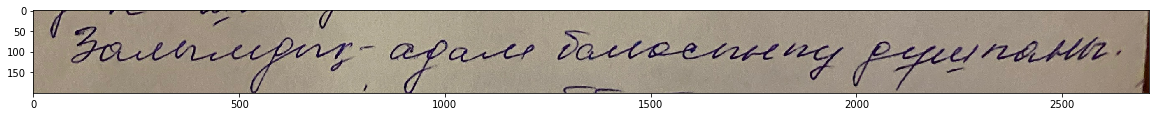

Text: "Залымдық-адам баласының дұшпаны."


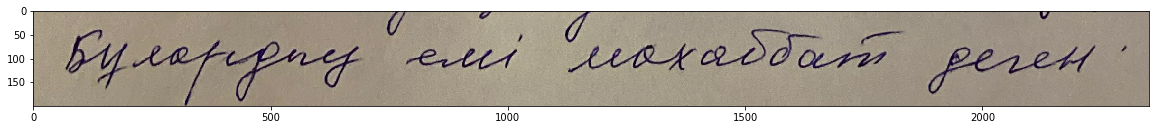

Text: "Бұлардың емі махаббат деген."


In [41]:
def crop(img, pos1, pos2, height):
    width = math.ceil(distance(pos1[0], pos1[1], pos2[0], pos2[1]))
    r = height / 2
    
    t = -math.pi / 2 + pos1[2]
    b = math.pi / 2 + pos1[2]
    
    lt = [r * math.cos(t) + pos1[0], r * math.sin(t) + pos1[1]]
    lb = [r * math.cos(b) + pos1[0], r * math.sin(b) + pos1[1]]
    
    t = -math.pi / 2 + pos2[2]
    b = math.pi / 2 + pos2[2]
    
    rt = [r * math.cos(t) + pos2[0], r * math.sin(t) + pos2[1]]
    rb = [r * math.cos(b) + pos2[0], r * math.sin(b) + pos2[1]]
    
    rect = np.float32([
        [lb[0], lb[1]],
        [rb[0], rb[1]],
        [rt[0], rt[1]],
        [lt[0], lt[1]],
    ])
    
    dst = np.float32([
        [0, height],
        [width, height],
        [width, 0],
        [0, 0],
    ])
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped
    
    
def pathCrop(img, positions, height):
    if len(positions) > 1:
        last = None
        cells = []
        for position in positions:
            if last is not None:
                cell = crop(img, last, position, height)
                cells.append(cell)
            last = position
            
        line = np.concatenate(cells, axis=1)
        return line
    else:
        return None
    


k = 2
dataset = DatasetManager(prefix + path)
img = cv2.cvtColor(dataset[k].getOriginal(), cv2.COLOR_BGR2RGB)


# data
#   lines
#      0.jpg
#      1.jpg
#   gt
#      0.txt


for i in range(len(dataset[k])):
    positions = dataset[k][i].segmentEqualDistance(50)
    line = pathCrop(img, positions, 200)
    plt.figure(figsize=(20, 2))
    plt.imshow(line)
    plt.show()
    print(dataset[k][i])

In [62]:
def build(dataset, directory, imgDirName, gtDirName, scales):
    
    imgDir = os.path.join(directory, imgDirName)
    if not os.path.exists(imgDir):
        os.makedirs(imgDir)
    
    gtDir = os.path.join(directory, gtDirName)
    if not os.path.exists(gtDir):
        os.makedirs(gtDir)
    
    idx = 0
    for paper in dataset:
        img = paper.getOriginal()
        
        for line in paper:
            positions = line.segmentEqualDistance(10)
            limg = pathCrop(img, positions, scales[str(paper)])
            text = line.text
            
            imgPath = os.path.join(imgDir, str(idx) + '.jpg')
            gtPath = os.path.join(gtDir, str(idx) + '.txt')
            
            f = open(gtPath, 'w')
            f.write(text)
            f.close()
            cv2.imwrite(imgPath, limg)
            
            idx += 1
            
            print('Processed:', idx)

In [64]:
build(dataset, 'built', 'lines', 'gt', {
    'paper_1': 80,
    'paper_2': 160,
    'paper_3': 200,
    'paper_4': 160,
    'paper_5': 160,
    
})

Processed: 1
Processed: 2
Processed: 3
Processed: 4
Processed: 5
Processed: 6
Processed: 7
Processed: 8
Processed: 9
Processed: 10
Processed: 11
Processed: 12
Processed: 13
Processed: 14
Processed: 15
Processed: 16
Processed: 17
Processed: 18
Processed: 19
Processed: 20
Processed: 21
Processed: 22
Processed: 23
Processed: 24
Processed: 25
Processed: 26
Processed: 27
Processed: 28
Processed: 29
Processed: 30
Processed: 31
Processed: 32
Processed: 33
Processed: 34
Processed: 35
Processed: 36
Processed: 37
Processed: 38
Processed: 39
Processed: 40
Processed: 41
Processed: 42
Processed: 43
Processed: 44
Processed: 45
Processed: 46
Processed: 47
Processed: 48
Processed: 49
Processed: 50
Processed: 51
Processed: 52
Processed: 53
Processed: 54
Processed: 55
Processed: 56
Processed: 57
Processed: 58
Processed: 59
Processed: 60
Processed: 61
Processed: 62
Processed: 63
Processed: 64
Processed: 65
Processed: 66
Processed: 67
Processed: 68
Processed: 69
Processed: 70
Processed: 71
Processed: 72
P